Get model predictions for best models trained

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks import *
from fastai.script import *

from data_utils import *
from models import *
from learn_utils import *

In [3]:
torch.cuda.set_device(7)

### data

In [4]:
data_dict.keys()

dict_keys(['notl_brain_mr', 'notl_brain_ct', 'atlas_brain_mr', 'notl_ventricle_mr', 'notl_ventricle_ct', 'atlas_ventricle_mr'])

Choose one of the datasets: 

- **MR_Dataset (Brain):** `notl_brain_mr`
- **CT_Dataset (Brain):** `notl_brain_ct`,
- **MR_Dataset (Ventricle):** `notl_ventricle_mr`,
- **CT_Dataset (Ventricle):** `notl_ventricle_ct`
- **Atlas_Dataset (Brain):** `atlas_brain_mr`
- **Atlas_Dataset (Ventricle):** `atlas_ventricle_mr`

In [5]:
data_name = 'notl_brain_mr'
f = data_dict[data_name]
train_paths, valid_paths, test1_paths, test2_paths = f()

In [6]:
train_ds = MRI_3D_Dataset(*train_paths)
valid_ds = MRI_3D_Dataset(*valid_paths)
test1_ds = MRI_3D_Dataset(*test1_paths) if test1_paths else None
test2_ds = MRI_3D_Dataset(*test2_paths) if test2_paths else None

In [7]:
bs = 1
data = DataBunch.create(train_ds=train_ds, valid_ds=valid_ds, bs=bs)
test1_dl = DeviceDataLoader(DataLoader(test1_ds, batch_size=bs), device=data.device) if test1_ds else None
test2_dl = DeviceDataLoader(DataLoader(test2_ds, batch_size=bs), device=data.device) if test2_ds else None

### model

In [8]:
model_name = 'baseline6'
f = experiment_model_dict[model_name]; m = f()

In [9]:
len(test2_paths[0])

20

### load model

Choose one of the model types: 

- **MR_Dataset (Brain) NOTL :** `notl_brain_mr_models`
- **MR_Dataset (Brain) TL :** `tl_brain_mr_models`

- **CT_Dataset (Brain) NOTL:** `notl_brain_ct_models`,
- **CT_Dataset (Brain) TL:** `tl_brain_ct_models`,

- **MR_Dataset (Ventricle) NOTL:** `notl_ventricle_mr_models`,
- **MR_Dataset (Ventricle) TL:** `tl_ventricle_mr_models`,

- **CT_Dataset (Ventricle) NOTL:** `notl_ventricle_ct_models`
- **CT_Dataset (Ventricle) TL:** `tl_ventricle_ct_models`

- **Atlas_Dataset (Brain):** `atlas_brain_mr_models`

- **Atlas_Dataset (Ventricle):** `atlas_ventricle_mr_models`

In [10]:
loss_func = 'dice'
model_dir = 'notl_brain_mr_models'
#model_dir = '../Vent_Seg_Models/notl_brain_mr_models/best_of_NOTL_Brain_MR_Baseline_6.pth'
learn = Learner(data=data, model=m, callbacks=[], callback_fns=[], model_dir=model_dir)
learn.loss_func = {'dice':dice_loss, 'bce':BCEWithLogitsFlat(), 'mixed':None}[loss_func] 
learn.metrics = [dice_score]
learn.to_fp16();

In [11]:
from IPython.display import display

In [12]:
try:
    display(sorted((learn.path/learn.model_dir).ls(), key=lambda o:int(o.stem.split('_')[-1])))
except:
    (display((learn.path/learn.model_dir).ls()))

[PosixPath('notl_brain_mr_models/best_of_NOTL_Brain_MR_Baseline_6.pth'),
 PosixPath('notl_brain_mr_models/final_of_NOTL_Brain_MR_Baseline_6.pth')]

In [24]:
#learn.load('best_of_TL_Ventricle_CT_Baseline_11');
learn.load('best_of_NOTL_Brain_MR_Baseline_6')

Learner(data=DataBunch;

Train: <data_utils.MRI_3D_Dataset object at 0x7f9b1990dc50>;

Valid: <data_utils.MRI_3D_Dataset object at 0x7f9b1990dc10>;

Test: None, model=MeshNet(
  (layers): Sequential(
    (0): Sequential(
      (0): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): PReLU(num_parameters=1)
      (2): GroupNorm(2, 8, eps=1e-05, affine=True)
      (3): Dropout3d(p=0)
    )
    (1): Sequential(
      (0): Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): PReLU(num_parameters=1)
      (2): GroupNorm(2, 8, eps=1e-05, affine=True)
      (3): Dropout3d(p=0)
    )
    (2): Sequential(
      (0): Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): PReLU(num_parameters=1)
      (2): GroupNorm(2, 8, eps=1e-05, affine=True)
      (3): Dropout3d(p=0)
    )
    (3): Sequential(
      (0): Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): PReLU(num_param

In [25]:
learn.validate(learn.data.valid_dl)

[0.067283615, tensor(0.9348)]

In [26]:
learn.to_fp32();

In [27]:
if test1_dl: print(learn.validate(test1_dl))

[0.058079354, tensor(0.9443)]


In [28]:
if test2_dl: print(learn.validate(test2_dl))

[0.10087112, tensor(0.9013)]


### logs

In [29]:
# path = Path("logs/"); path.ls()

# path = Path(f"logs/{model_dir}"); path.ls()

# log_df = pd.read_csv(path/'ATLAS_Brain_MR_Baseline_11.csv')

# log_df

# fig, ax = plt.subplots(1,1, figsize=(10,5))
# ax.set_title(f'Loss: {loss_func}')
# ax.set_xlabel("Epoch")
# ax.plot(log_df['train_loss'])
# ax.plot(log_df['valid_loss']);

# fig, ax = plt.subplots(1,1, figsize=(10,5))
# ax.set_title(f"Dice Score: {np.round(log_df['dice_score'].max(), 2)}")
# ax.set_xlabel("Epoch")
# plt.plot(log_df['dice_score']);

### Visualize

In [30]:
# def to_int8(a): return a.astype(np.uint8)

# data1 = DataBunch.create(train_ds=train_ds, valid_ds=valid_ds, test_ds=test1_ds, bs=3)
# data2 = DataBunch.create(train_ds=train_ds, valid_ds=valid_ds, test_ds=test2_ds, bs=3)

# train_fnames = data1.train_ds.img_fnames
# valid_fnames = data1.valid_ds.img_fnames
# test1_fnames = data1.test_ds.img_fnames
# test2_fnames = data1.test_ds.img_fnames

# len(train_fnames), len(valid_fnames), len(test1_fnames), len(test2_fnames)

# train_dl = data1.train_dl.new(shuffle=False)
# valid_dl = data1.valid_dl.new(shuffle=False)
# test1_dl = data1.test_dl.new(shuffle=False)
# test2_dl = data2.test_dl.new(shuffle=False)

# learn.to_fp16();

# # # training
# # images, preds, masks = get_img_pred_masks(learn, train_dl)

# # # validation
# # images, preds, masks = get_img_pred_masks(learn, valid_dl)

# # # test1
# # images, preds, masks = get_img_pred_masks(learn, test1_dl)

# # # test2
# # images, preds, masks = get_img_pred_masks(learn, test2_dl)

### Compare Deep Learning with Atlas

Skull strip train, valid, test1 and test2

- Compare with atlas masks
- RuntimeError: _th_cat is not implemented for type torch.HalfTensor
- Save to data_path/**/skull_stripped_v2

### Get Model Preds

In [31]:
def get_preds_targs(dl):
    test_preds, test_targs = get_preds(learn.model, dl)
    test_preds.squeeze_(1); test_preds.sigmoid_();
    return test_preds, test_targs

In [32]:
test1_preds, test1_targs = get_preds_targs(test1_dl)
test2_preds, test2_targs = get_preds_targs(test2_dl)

In [33]:
test1_preds.shape, test1_targs.shape

(torch.Size([15, 128, 256, 256]), torch.Size([15, 128, 256, 256]))

In [34]:
test2_preds.shape, test2_targs.shape

(torch.Size([20, 128, 256, 256]), torch.Size([20, 128, 256, 256]))

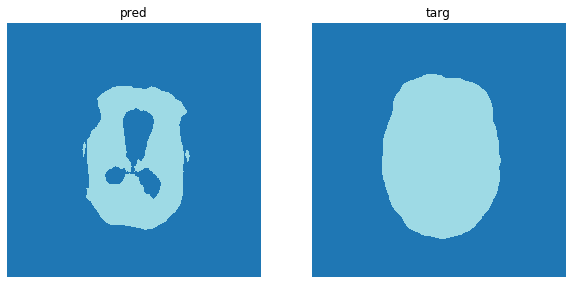

In [35]:
fig, ax = plt.subplots(1,2,figsize=(10,20))
ImageSegment(test1_preds[0][60][None,...]).show(ax=ax[0], alpha=1, cmap='tab20', title='pred')
ImageSegment(test1_targs[0][60][None,...]).show(ax=ax[1], alpha=1, cmap='tab20', title='targ')

### Save Model Predictions

In [146]:
save_path = Path("/home/turgutluk/data/Segmentation_Dataset/CT_Dataset/")

In [147]:
test1_savedir = save_path/'test1/ventricle_preds'; os.makedirs(test1_savedir, exist_ok=True)
test2_savedir = save_path/'test2/ventricle_preds'; os.makedirs(test2_savedir, exist_ok=True)

In [148]:
pd.to_pickle([test1_preds, test1_targs], test1_savedir/f'{model_name}_preds.pkl')
pd.to_pickle([test2_preds, test2_targs], test2_savedir/f'{model_name}_preds.pkl')

### Skull Stripping v2

- Human annotated brain masks will be used where possible
- "First, we normalize each modality of each patient independently by subtracting the mean and dividing by the standard deviation of the brain region. We then clip the resulting images at [−5, 5] to remove outliers and subsequently rescale to [0, 1], with the non-brain region being set to 0."

In [21]:
import seaborn as sns

In [22]:
parent_dataset = 'MR_Dataset_Atlas'

In [23]:
os.makedirs(data_path/f'{parent_dataset}/train/skull_stripped_v2', exist_ok=True)
os.makedirs(data_path/f'{parent_dataset}/validation/skull_stripped_v2', exist_ok=True)
if test1_ds: os.makedirs(data_path/f'{parent_dataset}/test1/skull_stripped_v2', exist_ok=True) 
if test2_ds: os.makedirs(data_path/f'{parent_dataset}/test2/skull_stripped_v2', exist_ok=True)

In [24]:
sorted((data_path/f'{parent_dataset}/train/raw_images').ls())[:2]

[PosixPath('../../data/Segmentation_Dataset/MR_Dataset_Atlas/train/raw_images/BrainMets-UCSF-00001_19990425000000.000_2.16.840_579.6972_RTst_1999-04-25_000000_._MR.Bias.Corrected,.axial.t1.g_n1__00000_MR.npy'),
 PosixPath('../../data/Segmentation_Dataset/MR_Dataset_Atlas/train/raw_images/BrainMets-UCSF-00004_19970413000000.000_2.16.840_482.7049_RTst_1997-04-13_000000_._MR.Bias.Corrected,.axial_n1__00000_MR.npy')]

In [25]:
sorted((data_path/f'{parent_dataset}/train/brain_atlas').ls())[:2]

[PosixPath('../../data/Segmentation_Dataset/MR_Dataset_Atlas/train/brain_atlas/BrainMets-UCSF-00001_19990425000000.000_2.16.840_579.6972_RTst_1999-04-25_000000_._MR.Bias.Corrected,.axial.t1.g_n1__00000_MR.npy'),
 PosixPath('../../data/Segmentation_Dataset/MR_Dataset_Atlas/train/brain_atlas/BrainMets-UCSF-00004_19970413000000.000_2.16.840_482.7049_RTst_1997-04-13_000000_._MR.Bias.Corrected,.axial_n1__00000_MR.npy')]

In [26]:
# raw_images = [np.load(fn) for fn in (data_path/f'{parent_dataset}/train/raw_images').ls()]
# # brain_masks = [np.load(fn) for fn in (data_path/f'{parent_dataset}/train/brain_masks').ls()]
# brain_masks = [np.load(fn) for fn in (data_path/f'{parent_dataset}/train/brain_atlas').ls()]

In [27]:
# len(raw_images), len(brain_masks)

In [ ]:
# pixel density plot of different scans
for i in range(10):
    sns.distplot(np.clip(raw_images[i][50:70].flatten(), 0, 400), hist=False)

In [28]:
def normalize_with_mask(image, mask):
    """
    First, we normalize each modality of each patient 
    independently by subtracting the mean and dividing by the standard deviation of the brain region.
    We then clip the resulting images at [−5, 5] to remove outliers and subsequently rescale to [0, 1],
    with the non-brain region being set to 0.
    """
    mx = np.ma.masked_array(image, mask=1-mask) # True for places that are masked, we want to exclude non-brain
    mean, std = mx.mean(), mx.std()
    return np.clip((image - mean) / std, -5, 5)*mask

In [ ]:
normalized_samples = [normalize_with_mask(image, mask) for image, mask in zip(raw_images[:10], brain_masks[:10])]

In [ ]:
# pixel density plot of normalized scans
for i in range(10):
    sns.distplot(np.clip(normalized_samples[i][50:70].flatten(), -2, 2), hist=False)

In [ ]:
fig, axes = plt.subplots(2,5, figsize=(15,6))
for i,ax in enumerate(axes.flatten()): ax.imshow(normalized_samples[i][64])

In [ ]:
train_fnames[0]

In [29]:
fnames_dict = {'train':train_fnames, 'validation':valid_fnames, 'test1':test1_fnames, 'test2':test2_fnames}

In [30]:
len(train_fnames), len(valid_fnames)

(2143, 15)

In [42]:
def strip_and_save(dataset, mask_dir='brain_masks'):
    fnames = fnames_dict[dataset]
    for fn in fnames:
        image = np.load(data_path/f'{parent_dataset}/{dataset}/raw_images/{fn.name}')
        mask = np.load(data_path/f'{parent_dataset}/{dataset}/{mask_dir}/{fn.name}')
        normalized_image = normalize_with_mask(image, mask)
        np.save(data_path/f'{parent_dataset}/{dataset}/skull_stripped_v2/{fn.name}', normalized_image)
        
#     parallel(_save, fnames)

In [ ]:
strip_and_save('train', mask_dir='brain_atlas')
strip_and_save('validation', mask_dir='brain_masks')
if test1_ds: strip_and_save('test1')
if test2_ds: strip_and_save('test2')

### old

In [64]:
# def get_predictions(model, dl):
#     res = []
#     model.eval()
#     with torch.no_grad():
#         for xb,yb in progress_bar(dl):
#             out = model(xb)
#             out = to_detach(out)
#             res.append(out)
#     res = torch.cat([o.float() for o in res]) # converts to fp32 cat doesn't work with fp16
#     return res

# data1 = DataBunch.create(train_ds=train_ds, valid_ds=valid_ds, test_ds=test1_ds, bs=2)
# data1.add_tfm(batch_to_half)
# data2 = DataBunch.create(train_ds=train_ds, valid_ds=valid_ds, test_ds=test2_ds, bs=2)
# data2.add_tfm(batch_to_half)

# train_dl = data1.train_dl.new(shuffle=False)
# valid_dl = data1.valid_dl.new(shuffle=False)
# test1_dl = data1.test_dl.new(shuffle=False) if test1_ds else None
# test2_dl = data2.test_dl.new(shuffle=False) if test2_ds else None

# test1_dl, test2_dl

# # my data copy path
# data_path = Path('../../data/Segmentation_Dataset/')

# train_fnames = data1.train_ds.img_fnames
# valid_fnames = data1.valid_ds.img_fnames
# test1_fnames = data1.test_ds.img_fnames if test1_ds else None 
# test2_fnames = data2.test_ds.img_fnames if test2_ds else None

# learn.to_fp16();

# # model predictions
# # train_preds = get_predictions(learn.model, train_dl)
# # valid_preds = get_predictions(learn.model, valid_dl)
# test1_preds = get_predictions(learn.model, test1_dl) if test1_ds else None
# test2_preds = get_predictions(learn.model, test2_dl) if test2_ds else None

# # train_preds.shape, valid_preds.shape, 
# test1_preds.shape, test2_preds.shape

#### Save Preds

In [65]:
# parent_dataset = 'MR_Dataset'
# # parent_dataset = 'CT_Dataset'

# test1_preds.squeeze_(1), test2_preds.squeeze_(1);

# test1_preds.shape, test2_preds.shape

# probas = True
# if not probas:
#     test1_preds_np = to_np(test1_preds) > 0
#     test2_preds_np = to_np(test2_preds) > 0
# else:
#     test1_preds_np = to_np(torch.sigmoid(test1_preds)) 
#     test2_preds_np = to_np(torch.sigmoid(test2_preds))

# test1_preds.shape, test2_preds.shape

# is_tl = False
# tl_str = 'notl' if not is_tl else 'tl'

# p1 = (data_path/parent_dataset/f'test1/{model_name}_{tl_str}_ventricle_probas')
# p2 = (data_path/parent_dataset/f'test2/{model_name}_{tl_str}_ventricle_probas')

# p1

# os.makedirs(p1, exist_ok=True)
# os.makedirs(p2, exist_ok=True)

# plt.imshow(test2_preds_np[8][64])

# from tqdm import tqdm_notebook

# for o, pred in tqdm_notebook(zip(test1_fnames, test1_preds_np)):
#     np.save(p1/o.name, pred)

# for o, pred in tqdm_notebook(zip(test2_fnames, test2_preds_np)):
#     np.save(p2/o.name, pred)

### old

In [67]:
# def collect_masks(dl): return torch.cat([to_cpu(yb) for _, yb in dl])

# # human annotated masks
# train_masks = collect_masks(train_dl)
# valid_masks = collect_masks(valid_dl)
# test1_masks = collect_masks(test1_dl) if test1_ds else None
# test2_masks = collect_masks(test2_dl) if test2_ds else None

# for masks in (train_masks, valid_masks, test1_masks, test2_masks):
#     masks.unsqueeze_(1)

# train_masks.shape, valid_masks.shape, test1_masks.shape, test2_masks.shape

# def load_atlas(path, fnames):
#     return torch.cat([torch.tensor(np.load(path/fn.name))[None] for fn in fnames])

# train_atlas_path = (data_path/f'{parent_dataset}/train/brain_atlas')
# valid_atlas_path = (data_path/f'{parent_dataset}/validation/brain_atlas')
# test1_atlas_path = (data_path/f'{parent_dataset}/test1/brain_atlas')
# test2_atlas_path = (data_path/f'{parent_dataset}/test2/brain_atlas')

# # machine annotated masks
# train_atlas = load_atlas(train_atlas_path, train_fnames)
# valid_atlas = load_atlas(valid_atlas_path, valid_fnames)
# test1_atlas = load_atlas(test1_atlas_path, test1_fnames)
# test2_atlas = load_atlas(test2_atlas_path, test2_fnames)

# for masks in (train_atlas, valid_atlas, test1_atlas, test2_atlas):
#     masks.unsqueeze_(1)

# train_atlas.shape, valid_atlas.shape, test1_atlas.shape, test2_atlas.shape

# image_no=5
# slice_no=64
# ImageSegment(train_preds[image_no, :, slice_no] > 0)

# image_no=5
# slice_no=64
# ImageSegment(train_masks[image_no, :, slice_no] > 0)

# image_no=5
# slice_no=64
# ImageSegment(train_atlas[image_no, :, slice_no] > 0)

# # deep learning performance
# train_preds_score = dice_score(train_preds, train_masks)
# valid_preds_score = dice_score(valid_preds, valid_masks)
# test1_preds_score = dice_score(test1_preds, test1_masks)
# test2_preds_score = dice_score(test2_preds, test2_masks)

# train_preds_score, valid_preds_score, test1_preds_score, test2_preds_score

# # atlas performance
# train_atlas_score = dice_score(train_atlas, train_masks)
# valid_atlas_score = dice_score(valid_atlas, valid_masks)
# test1_atlas_score = dice_score(test1_atlas, test1_masks)
# test2_atlas_score = dice_score(test2_atlas, test2_masks)

# train_atlas_score, valid_atlas_score, test1_atlas_score, test2_atlas_score